Make sure to open in colab to see the plots!


You might want to change the plot sizes; just ctrl+f for "figsize" and change them all (ex.: (20,4) to (10,2))

# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
!pip3 install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
!pip3 install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian, exponential

import warnings
warnings.filterwarnings('ignore')

# Curve Fitting Example

We want to fit the following curve:

In [2]:
def exponential_growth(x,A,k):
    return A*np.exp(x*k)

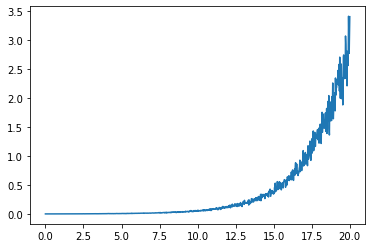

In [3]:
np.random.seed(42)
x = np.linspace(0, 20.0, 1001)

data = (exponential_growth(x, 0.001, 0.4) * (1.0 + np.random.normal(scale=0.1, size=x.size)))  # exponential distr. with some noise
plt.plot(x, data);

So we define a function that takes x as the first argument, and then the parameters to be fitted (a, b, c)

In [4]:
def f(x, a, b):
    return exponential_growth(x, a, b) 

In [5]:
mod = lmfit.Model(f)
# we set the parameters (and some initial parameter guesses)
mod.set_param_hint("a", value=0.02, vary=True)
mod.set_param_hint("b", value=0.5, vary=True)

params = mod.make_params()

In [6]:
result = mod.fit(data, params, method="leastsq", x=x)  # fitting

{'a': 0.0011015708523488322, 'b': 0.3951473987912008}

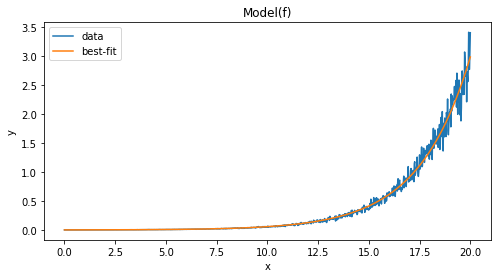

In [7]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [8]:
result

# Supplemental and Coronavirus Data

In [9]:
# !! if you get a timeout-error, just click on the link and download the data manually !!

# read the data
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]

# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

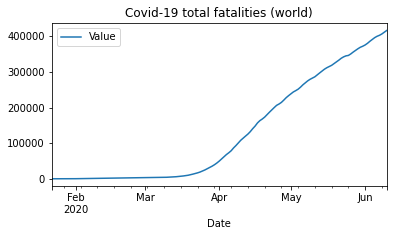

In [10]:
covid_data.groupby("Date").sum()[["Value"]].plot(figsize=(6, 3), title="Covid-19 total fatalities (world)");

## Plotting

In [42]:
plt.gcf().subplots_adjust(bottom=0.0)  # 0.15

def plotter(t, S, S_c, E, I, C, R, D, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(10,4))
    if x_ticks is None:
        ax.plot(t, S+S_c, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S+S_c, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()


    ax.title.set_text('extended SCEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    f = plt.figure(figsize=(10,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        beds = [B(t1) for t1 in t]
        ax1.plot(t, beds, 'b--', alpha=0.7, linewidth=2, label='Beds')
    else:
        ax1.plot(x_ticks, beds, 'b--', alpha=0.7, linewidth=2, label='Beds')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('Beds over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)   
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

# Model

In [12]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds, c_0, c_1, c_2):
    S, S_c, E, I, C, R, D = y

    dSdt = -beta * I * S / N - c_2 * I * C / N + c_1 * S_c
    dScdt = -c_0 * beta * I * S_c / N + c_2 * I * C / N - c_1 * S_c
    dEdt = beta * I * S / N + c_0 * beta * I * S_c / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dScdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [16]:
gamma = 1.0/9.0
sigma = 1.0/3.0

def Model(days, agegroups, beds_per_100k, c_0, c_1, c_2, beta, prob_I_to_C, prob_C_to_D, s):

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds, c_0, c_1, c_2))
    S, S_c, E, I, C, R, D = ret.T
    

    return t, S, S_c, E, I, C, R, D, Beds, prob_I_to_C, prob_C_to_D

In [15]:
R_0_start =  3.5326417299176263
R_0_end= 0.5805588854923937
k = 4.946919439058942
x0 = 84.59149094407722
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end
logistic_R_0(0., R_0_start, k, x0, R_0_end)

3.5326417299176263

percentage going to ICU: 5.0; percentage dying in ICU: 60.0


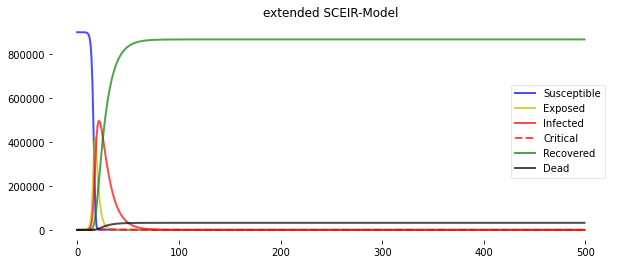

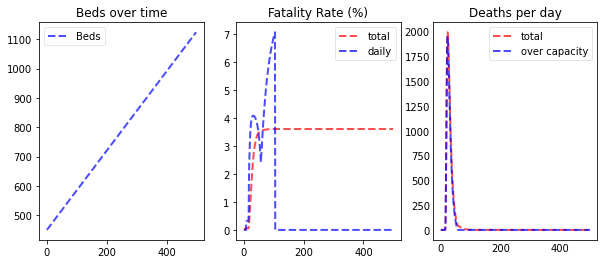

In [43]:
plotter(*Model(days=500, agegroups=[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000], 
               beds_per_100k=50, c_0=0.3, c_1=1.0/14.,c_2=1.0, beta=3.53, 
               prob_I_to_C=0.05, prob_C_to_D=0.6, s=0.003))

# Fitting

In [70]:
# parameters
data = covid_data[covid_data["Location"] == "Italy"]["Value"].values[::-1]
agegroups = agegroup_lookup["Italy"]
beds_per_100k = beds_lookup["Italy"]
outbreak_shift = 30
params_init_min_max = {"c_0": (0.3, 0.2, 0.5), "c_1": (0.07, 0.03, 0.1),
                       "c_2": (1000.0, 100.,10000.),"beta": (0.35, 0.2, 0.7),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [71]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, c_0, c_1, c_2, beta, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, c_0, c_1, c_2, beta, prob_I_to_C, prob_C_to_D, s)
    return ret[7][x]

In [72]:
def fitter(x, c_0, c_1, c_2, beta, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, c_0, c_1, c_2, beta,  prob_I_to_C, prob_C_to_D, s)
    return ret[7][x]

In [73]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [74]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

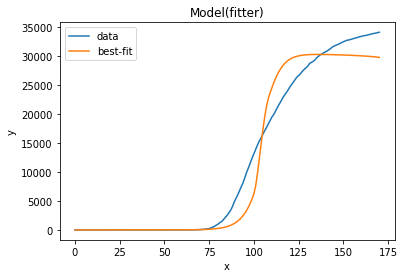

In [75]:
result.plot_fit(datafmt="-");

In [76]:
result.best_values

{'c_0': 0.20000009996007595,
 'c_1': 0.03000008439886498,
 'c_2': 9248.630014020046,
 'beta': 0.416092818936816,
 'prob_I_to_C': 0.010000000569649043,
 'prob_C_to_D': 0.4466626275346837,
 's': 0.009999999999767162}

Prediction for Italy
percentage going to ICU: 1.0000000569649043; percentage dying in ICU: 44.666262753468374


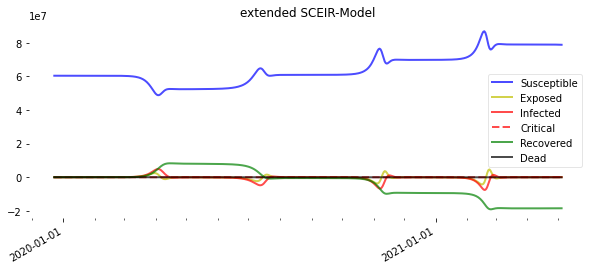

UnboundLocalError: local variable 'beds' referenced before assignment

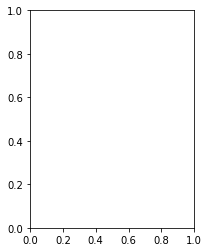

In [77]:
full_days = 500
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for Italy")
plotter(*Model(full_days, agegroup_lookup["Italy"], beds_lookup["Italy"], **result.best_values), x_ticks=x_ticks);